In [95]:

import sys
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from utils import read_mtx
from plot import plot_embedding,plot_clustercounts

%matplotlib inline


In [4]:
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=False)
cluster_anno=pd.read_csv('data/Hematopoiesis-All/cluster_anno.txt', sep='\t', header=None, index_col=0)
cluster_anno=cluster_anno[1].to_dict()
hema['ClusterName']=hema.apply(lambda x: cluster_anno[x['Clusters']], axis=1)

In [57]:
hema.head()

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,Group_Barcode,ClusterName
0,-2.419656,7.603472,Cluster6,Bone_Marrow_Rep1,29301,0.347190,CAAGAAAGTCAAGACG-1,SUHealthy_BM_B1_50,Bone_Marrow_Rep1#CAAGAAAGTCAAGACG-1,6-Pro-B
1,5.676727,-9.210454,Cluster20,Bone_Marrow_Rep1,7534,0.290948,AATGCCATCGCACAAT-1,SUHealthy_BM_B1_51,Bone_Marrow_Rep1#AATGCCATCGCACAAT-1,20-Mature NK2
2,-7.153399,-5.512960,Cluster11,Bone_Marrow_Rep1,29608,0.449186,AAAGGGCAGTACCCAT-1,SUHealthy_BM_B1_52,Bone_Marrow_Rep1#AAAGGGCAGTACCCAT-1,11-cDC
3,-8.475636,-5.377475,Cluster9,Bone_Marrow_Rep1,16810,0.498632,CACAACATCGTGGGTC-1,SUHealthy_BM_B1_53,Bone_Marrow_Rep1#CACAACATCGTGGGTC-1,9-MDP
4,8.297910,-3.170289,Cluster31,Bone_Marrow_Rep1,14890,0.333277,TCCATCGGTTGGTAAA-1,SUHealthy_BM_B1_54,Bone_Marrow_Rep1#TCCATCGGTTGGTAAA-1,31-Gamma delta T


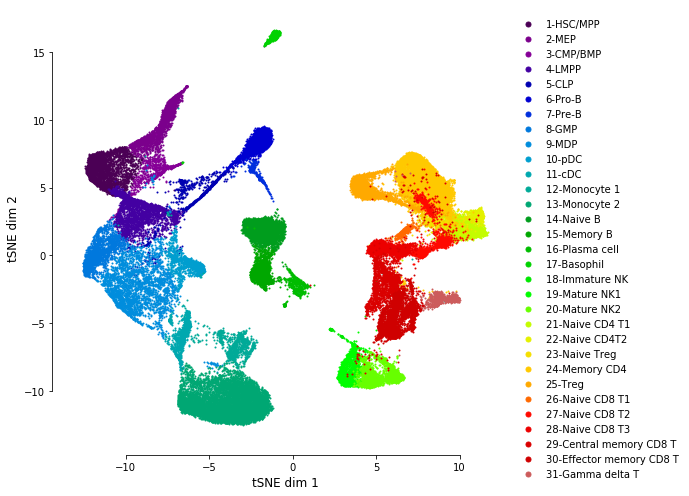

In [70]:
plot_embedding(np.array(hema[['UMAP1','UMAP2']]), hema['ClusterName'], classes=cluster_anno.values(),
               cmap='nipy_spectral', figsize=(8,8),markersize=1)

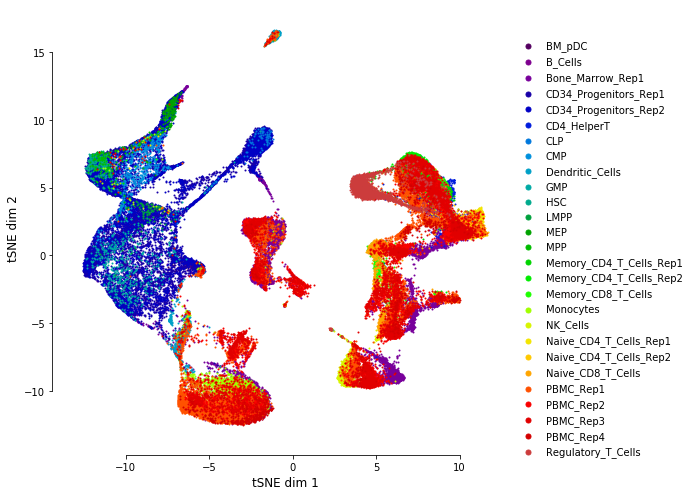

In [42]:
plot_embedding(np.array(hema[['UMAP1','UMAP2']]), hema['Group'], 
               cmap='nipy_spectral', figsize=(8,8),markersize=1)

In [83]:
cluster_counts=hema['ClusterName'].value_counts()
cluster_counts=cluster_counts.loc[cluster_anno.values()]

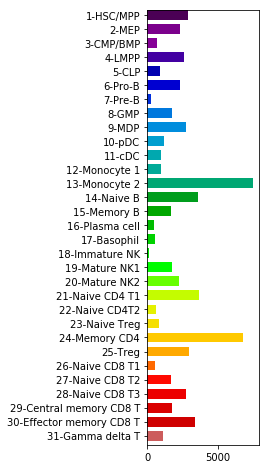

In [99]:
plot_clustercounts(cluster_counts,clusters=list(cluster_anno.values()), 
                   cmap='nipy_spectral',width=0.7,figsize=(2,8),yticks=True)

In [105]:
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from glob import glob
import os

def read_anndata(path):
    for filename in glob(path+'/*'):
        basename = os.path.basename(filename)
        if (('count' in basename) or ('matrix' in basename)) and ('mtx' in basename):
            count = mmread(filename)
        elif 'barcode' in basename or 'cell' in basename:
            cell_id = pd.read_csv(filename, sep='\t', header=None)[0].values
        elif 'gene' in basename or 'peak' in basename:
            feature = pd.read_csv(filename, sep='\t', header=None)[0].values
    adata = sc.AnnData(count, feature, cell_id)
    return adata

In [110]:
count = mmread('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.count.mtx')
obs = pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', sep='\t', header=0, index_col=-1)
var = pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.peaks.txt', sep='\t', header=0, index_col=0)

In [134]:
count_csr=count.T.tocsr()
print(count_csr[:4,:4])

  (0, 0)	2
  (1, 0)	2
  (2, 0)	2
  (3, 0)	2


In [135]:
print(sys.getsizeof(adata),sys.getsizeof(count),sys.getsizeof(count_csr))

86933946 56 56


In [137]:
adata=sc.AnnData(count_csr, obs=obs, var=var)

In [138]:
sys.getsizeof(adata)

89555290

In [139]:
adata.shape

(63882, 571400)

In [144]:
adata.obs.shape

(63882, 9)

In [145]:
adata.obs['clusters']=hema['ClusterName'].values
adata.obs.head()

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,clusters
Group_Barcode,,,,,,,,,
Bone_Marrow_Rep1#CAAGAAAGTCAAGACG-1,-2.419656,7.603472,Cluster6,Bone_Marrow_Rep1,29301,0.347190,CAAGAAAGTCAAGACG-1,SUHealthy_BM_B1_50,6-Pro-B
Bone_Marrow_Rep1#AATGCCATCGCACAAT-1,5.676727,-9.210454,Cluster20,Bone_Marrow_Rep1,7534,0.290948,AATGCCATCGCACAAT-1,SUHealthy_BM_B1_51,20-Mature NK2
Bone_Marrow_Rep1#AAAGGGCAGTACCCAT-1,-7.153399,-5.512960,Cluster11,Bone_Marrow_Rep1,29608,0.449186,AAAGGGCAGTACCCAT-1,SUHealthy_BM_B1_52,11-cDC
Bone_Marrow_Rep1#CACAACATCGTGGGTC-1,-8.475636,-5.377475,Cluster9,Bone_Marrow_Rep1,16810,0.498632,CACAACATCGTGGGTC-1,SUHealthy_BM_B1_53,9-MDP
Bone_Marrow_Rep1#TCCATCGGTTGGTAAA-1,8.297910,-3.170289,Cluster31,Bone_Marrow_Rep1,14890,0.333277,TCCATCGGTTGGTAAA-1,SUHealthy_BM_B1_54,31-Gamma delta T


In [146]:
adata.write('data/Hematopoiesis-All/adata.h5ad')

... storing 'clusters' as categorical


In [147]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [148]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, standard_scale='var')

         Falling back to preprocessing with `sc.pp.pca` and default params.


MemoryError: 

In [151]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head()

,1-HSC/MPP,2-MEP,3-CMP/BMP,4-LMPP,5-CLP,6-Pro-B,7-Pre-B,8-GMP,9-MDP,10-pDC,...,22-Naive CD4T2,23-Naive Treg,24-Memory CD4,25-Treg,26-Naive CD8 T1,27-Naive CD8 T2,28-Naive CD8 T3,29-Central memory CD8 T,30-Effector memory CD8 T,31-Gamma delta T
0,chr16_73430412_73430912,chr2_70026182_70026682,chr5_118666145_118666645,chr6_162250279_162250779,chr10_133575560_133576060,chr4_5188442_5188942,chr10_1618877_1619377,chr17_66129445_66129945,chr17_29055518_29056018,chr7_98270898_98271398,...,chr8_19354614_19355114,chr17_80084566_80085066,chr17_80084566_80085066,chr8_29208128_29208628,chr17_80084566_80085066,chr17_80084566_80085066,chr17_80084566_80085066,chr17_80084566_80085066,chr2_87013156_87013656,chr17_80867397_80867897
1,chr22_33277237_33277737,chr22_30129644_30130144,chr6_7975397_7975897,chr22_28007931_28008431,chr16_67581594_67582094,chr10_1618877_1619377,chr10_126289948_126290448,chr19_13048091_13048591,chr8_133907698_133908198,chr6_11730816_11731316,...,chr17_80084566_80085066,chr1_60280101_60280601,chr1_6520371_6520871,chr11_48022939_48023439,chr6_111408333_111408833,chr19_3275827_3276327,chr11_66085228_66085728,chr2_61046568_61047068,chr1_25237480_25237980,chr7_151105799_151106299
2,chr20_31269123_31269623,chr1_110336934_110337434,chr7_50564605_50565105,chr8_30280653_30281153,chr7_2774601_2775101,chr19_1856242_1856742,chr5_172277081_172277581,chr6_7154811_7155311,chr17_76194882_76195382,chr1_213154901_213155401,...,chr11_60753556_60754056,chr8_19354614_19355114,chr15_69760714_69761214,chr13_24825532_24826032,chr1_60280101_60280601,chr6_29676434_29676934,chr2_87012592_87013092,chr12_120426403_120426903,chr2_9843237_9843737,chr1_57773065_57773565
3,chr8_30280653_30281153,chr4_10182653_10183153,chr7_73300384_73300884,chr10_133575560_133576060,chr7_98270898_98271398,chr12_123616513_123617013,chr12_113512981_113513481,chr8_29631125_29631625,chr10_133575560_133576060,chr3_194117618_194118118,...,chr10_63943135_63943635,chr13_40761266_40761766,chr7_151105799_151106299,chr15_65186795_65187295,chr22_30831513_30832013,chr5_35854359_35854859,chr11_60753556_60754056,chr1_25237480_25237980,chr17_45907195_45907695,chr11_113936813_113937313
4,chr14_89631676_89632176,chr1_164681411_164681911,chr16_22227811_22228311,chr7_98270898_98271398,chr4_5188442_5188942,chr3_13316032_13316532,chr1_31896256_31896756,chr12_2404013_2404513,chr7_98399624_98400124,chr5_54082007_54082507,...,chr2_97628617_97629117,chr8_8085306_8085806,chr12_120426403_120426903,chr10_97591974_97592474,chr1_95392563_95393063,chr6_138145231_138145731,chr2_87053102_87053602,chr11_48022939_48023439,chr12_121995592_121996092,chr15_91399858_91400358


In [152]:
pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']).head()

,1-HSC/MPP,2-MEP,3-CMP/BMP,4-LMPP,5-CLP,6-Pro-B,7-Pre-B,8-GMP,9-MDP,10-pDC,...,22-Naive CD4T2,23-Naive Treg,24-Memory CD4,25-Treg,26-Naive CD8 T1,27-Naive CD8 T2,28-Naive CD8 T3,29-Central memory CD8 T,30-Effector memory CD8 T,31-Gamma delta T
0,5.571032e-277,0.000000e+00,1.243341e-66,4.582531e-222,3.476174e-87,0.0,2.914459e-63,3.496766e-238,2.792006e-302,4.923285e-180,...,2.789277e-80,4.306545e-39,0.0,3.718446e-201,2.455736e-32,3.857397e-143,1.305384e-226,1.430978e-215,0.000000e+00,5.729220e-168
1,9.359215e-267,0.000000e+00,4.611668e-63,1.605206e-202,1.770027e-78,0.0,4.506841e-58,2.715111e-205,7.692743e-279,1.231620e-172,...,9.256030e-71,8.527992e-35,0.0,1.160755e-180,4.593809e-28,9.477245e-94,1.068795e-176,1.046482e-188,1.129672e-286,2.845234e-150
2,4.127529e-257,0.000000e+00,3.461400e-57,1.009838e-199,1.770027e-78,0.0,3.484062e-54,7.134079e-191,1.146500e-257,1.911663e-152,...,1.455524e-62,1.346625e-24,0.0,6.813828e-173,6.930651e-23,3.040721e-86,3.053630e-172,1.791701e-188,2.179669e-285,2.676082e-138
3,3.488213e-226,3.605809e-304,6.227937e-54,1.110228e-187,3.966119e-76,0.0,3.774892e-53,1.931866e-183,8.648581e-257,2.717362e-149,...,1.138621e-59,9.747370e-24,0.0,2.541769e-167,1.649965e-18,7.313533e-68,4.867196e-169,8.157397e-188,2.057212e-278,9.950000e-132
4,9.916279e-214,1.221644e-298,7.973558e-54,1.235832e-180,1.710842e-75,0.0,3.509712e-52,1.190894e-173,1.746216e-239,2.772843e-146,...,2.023741e-58,4.665495e-20,0.0,3.700851e-166,1.649965e-18,1.539130e-65,3.794522e-155,3.205194e-184,5.739597e-264,2.159199e-126


In [163]:
#specific_genes=pd.DataFrame(adata.uns['rank_genes_groups']['names']).loc[0:20,:].T.values.flatten()
#X2=pd.DataFrame(adata[:,specific_genes].X.todense()).T
X2.index=specific_genes
X2.columns=adata.obs['clusters']
X2_group=X2.T
X2_group['clusters']=X2_group.index
X2_group=X2_group.groupby('clusters').mean().T
X2=X2_group


ValueError: 'clusters' is both an index level and a column label, which is ambiguous.

In [164]:
X2_group.head()

,chr16_73430412_73430912,chr22_33277237_33277737,chr20_31269123_31269623,chr8_30280653_30281153,chr14_89631676_89632176,chr4_105864498_105864998,chr7_73300384_73300884,chr17_40471876_40472376,chr7_20259470_20259970,chr5_27172060_27172560,...,chr3_148727440_148727940,chr8_37728428_37728928,chr15_69760714_69761214,chr9_37503736_37504236,chr20_3646432_3646932,chr22_39486378_39486878,chr16_88686252_88686752,chr11_113944620_113945120,chr1_206910317_206910817,clusters
clusters,,,,,,,,,,,,,,,,,,,,,
6-Pro-B,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6-Pro-B
20-Mature NK2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,20-Mature NK2
11-cDC,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11-cDC
9-MDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9-MDP
31-Gamma delta T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,31-Gamma delta T


In [162]:
X2=pd.DataFrame(adata[:,specific_genes].X.todense()).T
X2.head()

,0,1,2,3,4,5,6,7,8,9,...,63872,63873,63874,63875,63876,63877,63878,63879,63880,63881
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0
4,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
adata

AnnData object with n_obs × n_vars = 63882 × 571400 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'clusters'
    uns: 'rank_genes_groups'

In [158]:
specific_genes[:5]

array(['chr16_73430412_73430912', 'chr22_33277237_33277737',
       'chr20_31269123_31269623', 'chr8_30280653_30281153',
       'chr14_89631676_89632176'], dtype=object)

In [156]:
X2.head()

,0,1,2,3,4,5,6,7,8,9,...,63872,63873,63874,63875,63876,63877,63878,63879,63880,63881
0,"(0, 130)\t4.0\n (0, 529)\t2.0\n (0, 23)\t3...","(0, 413)\t2.0\n (0, 249)\t2.0\n (0, 409)\t...","(0, 216)\t2.0\n (0, 146)\t2.0\n (0, 342)\t...","(0, 160)\t1.0\n (0, 251)\t1.0\n (0, 262)\t...","(0, 484)\t5.0\n (0, 518)\t2.0\n (0, 586)\t...","(0, 484)\t1.0\n (0, 382)\t2.0\n (0, 639)\t...","(0, 216)\t5.0\n (0, 162)\t2.0\n (0, 501)\t...","(0, 30)\t7.0\n (0, 527)\t2.0\n (0, 463)\t2...","(0, 382)\t2.0\n (0, 639)\t2.0\n (0, 591)\t...","(0, 216)\t4.0\n (0, 245)\t1.0\n (0, 146)\t...",...,"(0, 216)\t2.0\n (0, 245)\t2.0\n (0, 183)\t...","(0, 586)\t1.0\n (0, 431)\t1.0\n (0, 216)\t...","(0, 586)\t2.0\n (0, 431)\t2.0\n (0, 245)\t...","(0, 371)\t1.0\n (0, 245)\t2.0\n (0, 198)\t...","(0, 216)\t3.0\n (0, 146)\t2.0\n (0, 199)\t...","(0, 245)\t1.0\n (0, 146)\t2.0\n (0, 257)\t...","(0, 130)\t2.0\n (0, 198)\t2.0\n (0, 199)\t...","(0, 192)\t1.0\n (0, 532)\t3.0\n (0, 9)\t2....","(0, 299)\t2.0\n (0, 290)\t2.0\n (0, 191)\t...","(0, 130)\t4.0\n (0, 141)\t2.0\n (0, 614)\t..."


In [ ]:
plot_heatmap(X2, y=X2.columns, #row_labels=specific_genes, 
                 ncol=3, cmap='Reds',vmax=1, row_cluster=False, legend_font=6, cax_title='Promoter Value',
                figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(0.8, 0.76, 0.1, 0.015),
                save=save_prefix+'promoter_accessibility.png')

In [ ]:
specific_genes=pd.DataFrame(seurat.uns['rank_genes_groups']['names']).loc[0:20,:].T.values.flatten()
X=pd.DataFrame(seurat[:,specific_genes].layers['norm_data']).T
X.index=specific_genes
X.columns=seurat.obs['clusters']
from scale_plot_feature import plot_heatmap
plot_heatmap(X, y=seurat.obs['clusters'], #row_labels=specific_genes, 
                     ncol=3, cmap='Reds',vmax=1, row_cluster=False, legend_font=6, cax_title='Peak Value',
                    figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(0.8, 0.76, 0.1, 0.015),
                     save='test_specific_feature.png')


In [ ]:
def sort_by_classes(X, y, classes):
    if classes is None:
        classes = np.unique(y)
    index = []
    for c in classes:
        ind = np.where(y==c)[0]
        index.append(ind)
    index = np.concatenate(index)
    X = X.iloc[:, index]
    y = y[index]
    return X, y, classes, index

def plot_heatmap(X, y, classes=None, y_pred=None, row_labels=None, colormap=None, row_cluster=False,
                 cax_title='', xlabel='', ylabel='', yticklabels='', legend_font=10, 
                 show_legend=True, show_cax=True, tick_color='black', ncol=3,
                 bbox_to_anchor=(0.5, 1.3), position=(0.8, 0.78, .1, .04), return_grid=False,
                 save=None, **kw):
    """
    plot hidden code heatmap with labels

    Params:
        X: fxn array, n is sample number, f is feature
        y: a array of labels for n elements or a list of array
    """

    import matplotlib.patches as mpatches  # add legend
    # if classes is not None:
    X, y, classes, index = sort_by_classes(X, y, classes)
    # else:
        # classes = np.unique(y)

    if y_pred is not None:
        y_pred = y_pred[index]
        classes = list(classes) + list(np.unique(y_pred)) 
        if colormap is None:
            colormap = plt.cm.tab20
            colors = {c:colormap(i) for i, c in enumerate(classes)}
        else:
            colors = {c:colormap[i] for i, c in enumerate(classes)}
        col_colors = []
        col_colors.append([colors[c] for c in y])
        col_colors.append([colors[c] for c in y_pred])
    else:
        if colormap is None:
            colormap = plt.cm.tab20
            colors = {c:colormap(i) for i, c in enumerate(classes)}
        else:
            colors = {c:colormap[i] for i, c in enumerate(classes)}
        col_colors = [ colors[c] for c in y ]
        
    legend_TN = [mpatches.Patch(color=color, label=c) for c, color in colors.items()]

    if row_labels is not None:
        row_colors = [ colors[c] for c in row_labels ]
        kw.update({'row_colors':row_colors})

    kw.update({'col_colors':col_colors})

    cbar_kws={"orientation": "horizontal"}
    grid = sns.clustermap(X, yticklabels=True, 
            col_cluster=False,
            row_cluster=row_cluster,
            cbar_kws=cbar_kws, **kw)
    if show_cax:
        grid.cax.set_position(position)
        grid.cax.tick_params(length=1, labelsize=4, rotation=0)
        grid.cax.set_title(cax_title, fontsize=6, y=0.35)

    if show_legend:
        grid.ax_heatmap.legend(loc='upper center', 
                               bbox_to_anchor=bbox_to_anchor, 
                               handles=legend_TN, 
                               fontsize=legend_font, 
                               frameon=False, 
                               ncol=ncol)
        grid.ax_col_colors.tick_params(labelsize=6, length=0, labelcolor='orange')
        grid.cax.set_position(position)
        grid.cax.tick_params(length=1, labelsize=4, rotation=0)
        grid.cax.set_title(cax_title, fontsize=6, y=0.35)

    if show_legend:
        grid.ax_heatmap.legend(loc='upper center', 
                               bbox_to_anchor=bbox_to_anchor, 
                               handles=legend_TN, 
                               fontsize=legend_font, 
                               frameon=False, 
                               ncol=ncol)
        grid.ax_col_colors.tick_params(labelsize=6, length=0, labelcolor='orange')

    if (row_cluster==True) and (yticklabels is not ''):
        yticklabels = yticklabels[grid.dendrogram_row.reordered_ind]

    grid.ax_heatmap.set_xlabel(xlabel)
    grid.ax_heatmap.set_ylabel(ylabel, fontsize=8)
    grid.ax_heatmap.set_xticklabels('')
    grid.ax_heatmap.set_yticklabels(yticklabels, color=tick_color)
    grid.ax_heatmap.yaxis.set_label_position('left')
    grid.ax_heatmap.tick_params(axis='x', length=0)
    grid.ax_heatmap.tick_params(axis='y', labelsize=6, length=0, rotation=0, labelleft=True, labelright=False)
    grid.ax_row_dendrogram.set_visible(False)
    grid.cax.set_visible(show_cax)
    grid.row_color_labels = classes

    if save:
        plt.savefig(save, bbox_inches='tight')
    else:
        plt.show()
    if return_grid:
        return grid
